# Detección de crecimiento urbano con imagenes del satélite Sentinel - 1

## 2_ Predicción

Este notebook genera la prediccion del modelo sobre un nuevo dataset. Para ello primero descargamos las imagenes satelitales y luego con satproc generamos el dataset de predicción con el formato necesario para el modelo de ML


**Definicion de los parametros para la predicción**

In [30]:
MODELO_AREA = "atlantico"

PROVINCE = "vichada"

BANDS="VHa_VVa_VHaVVa" # "VHd_VVd_VHdVVd"

YEAR = "2021"

BUCKET = f"gs://dym-indunor-temp/immap/annotations_WASH/images/s1/{YEAR}/otros/{PROVINCE}/{BANDS}_bands_{YEAR}*"

BUCKET_MOUNTAINS = f"gs://dym-indunor-temp/immap/annotations_WASH/images/DEM/otros/vinchada*"#{PROVINCE}*"

MOUNT_FOLDER = f"mountain_masks/{PROVINCE}/"
ELEVATION_FILE = "mask_lt_25_.tif"


BASE_PATH = "../"
IMG_PATH = f"imagenes_s1_{MODELO_AREA}"

PROVINCE_AREA_FILE_NAME = f"{PROVINCE}.geojson"


#model
SIZE  = 100
MODEL = f'UNet_TEST_160x160_spe100_3N_spe100_colombia_{MODELO_AREA}.h5'


#post-process
UMBRAL = 130
THR = 0.5
MIN_AREA = 10 #not used

BUCKET_RESULTADOS = f'gs://dym-indunor-temp/immap/resultados/{MODELO_AREA}/{PROVINCE}/'


**Descarga de las imagenes de predicción**

Descarga las imagenes del bucket

In [2]:
img_folder = f'{BASE_PATH}{IMG_PATH}/{YEAR}/{PROVINCE}'
!mkdir -p $img_folder
!gsutil -m cp -r $BUCKET  $img_folder

Copying gs://dym-indunor-temp/immap/annotations_WASH/images/s1/2017/otros/vichada/VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif...
Copying gs://dym-indunor-temp/immap/annotations_WASH/images/s1/2017/otros/vichada/VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif...
Copying gs://dym-indunor-temp/immap/annotations_WASH/images/s1/2017/otros/vichada/VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif...
Copying gs://dym-indunor-temp/immap/annotations_WASH/images/s1/2017/otros/vichada/VHa_VVa_VHaVVa_bands_2017_0000000000-0000040704.tif...
Copying gs://dym-indunor-temp/immap/annotations_WASH/images/s1/2017/otros/vichada/VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif...
Copying gs://dym-indunor-temp/immap/annotations_WASH/images/s1/2017/otros/vichada/VHa_VVa_VHaVVa_bands_2017_0000027136-0000027136.tif...
Copying gs://dym-indunor-temp/immap/annotations_WASH/images/s1/2017/otros/vichada/VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif...
Copying gs://dym-indunor-temp/immap/annot

### Satproc

Con esta herramienta genereamos un dataset de imágenes de predicción que, a diferencia del de entrenamiento, solo contiene imágenes.

Pasamos la ruta de las imágenes de predicción y la ruta donde queremos que se guarde el resultado.



In [81]:
#!ls ../data/shp/

In [3]:
size = SIZE
step_size = SIZE

path_to_files  = f'{BASE_PATH}{IMG_PATH}/{YEAR}/{PROVINCE}/*.tif'
dataset_folder = f'{BASE_PATH}/dataset_{MODELO_AREA}/data_predict/province_{PROVINCE}/{YEAR}/{str(size)}_{str(step_size)}/'
aoi_predict    = f'{BASE_PATH}/data/shp/{PROVINCE_AREA_FILE_NAME}'

*Obs*: Dado que aquí nos interesa predecir sobre toda la imágen y por ende no tener overlaps,  *step_size* debe ser igual a *size*.

In [83]:
#!satproc_extract_chips --help

In [4]:
#10-15 min aprox
!satproc_extract_chips $path_to_files \
                -o $dataset_folder \
                --aoi $aoi_predict \
                --size $size \
                --step-size $step_size \
                --rescale \
                --rescale-mode values --min -15 --max 5

Rasters:   0%|                                           | 0/12 [00:00<?, ?it/s]
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   0%| | 0/5651 [00:
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   0%| | 3/5651 [00:
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   0%| | 17/5651 [00
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   1%| | 37/5651 [00
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   1%| | 51/5651 [00
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   1%| | 77/5651 [00
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   2%| | 94/5651 [00
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   2%| | 111/5651 [0
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   2%| | 137/5651 [0
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   3%| | 155/5651 [0
VHa_VVa_VHaVVa_bands_2017_0000000000-0000000000.tif windows:   3%| | 173/5651 [0
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   5%| | 758/15453 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   5%| | 802/15453 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   6%| | 855/15453 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   6%| | 895/15453 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   6%| | 927/15453 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   6%| | 953/15453 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   6%| | 975/15453 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   7%| | 1028/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   7%| | 1065/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   7%| | 1097/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   7%| | 1122/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:   7%| | 1144/15453 
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  53%|5| 8162/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  53%|5| 8214/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  53%|5| 8267/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  54%|5| 8319/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  54%|5| 8364/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  54%|5| 8399/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  55%|5| 8427/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  55%|5| 8451/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  55%|5| 8496/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  55%|5| 8548/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  56%|5| 8598/15453 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000013568.tif windows:  56%|5| 8648/15453 
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   1%| | 113/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   1%| | 131/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   1%| | 167/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   1%| | 189/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   1%| | 208/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   2%| | 252/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   2%| | 295/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   2%| | 326/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   2%| | 350/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   3%| | 371/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   3%| | 404/14264 [
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:   3%| | 436/14264 [
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  51%|5| 7285/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  51%|5| 7339/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  52%|5| 7392/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  52%|5| 7436/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  52%|5| 7473/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  53%|5| 7503/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  53%|5| 7528/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  53%|5| 7580/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  54%|5| 7632/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  54%|5| 7669/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  54%|5| 7699/14264 
VHa_VVa_VHaVVa_bands_2017_0000000000-0000027136.tif windows:  54%|5| 7724/14264 
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   1%| | 186/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   1%| | 237/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   1%| | 271/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   2%| | 299/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   2%| | 322/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   2%| | 342/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   2%| | 360/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   2%| | 388/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   2%| | 440/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   3%| | 490/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   3%| | 541/18322 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:   3%| | 593/18322 [
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  41%|4| 7518/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  41%|4| 7563/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  42%|4| 7616/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  42%|4| 7659/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  42%|4| 7695/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  42%|4| 7725/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  42%|4| 7750/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  42%|4| 7771/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  43%|4| 7790/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  43%|4| 7842/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  43%|4| 7893/18322 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  43%|4| 7945/18322 
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  83%|8| 15124/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  83%|8| 15176/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  83%|8| 15226/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  83%|8| 15277/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  84%|8| 15328/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  84%|8| 15373/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  84%|8| 15411/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  84%|8| 15441/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  84%|8| 15466/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  85%|8| 15488/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  85%|8| 15541/18322
VHa_VVa_VHaVVa_bands_2017_0000013568-0000000000.tif windows:  85%|8| 15593/18322
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  22%|2| 3977/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  22%|2| 4028/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  22%|2| 4064/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  22%|2| 4096/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  22%|2| 4122/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  22%|2| 4144/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  23%|2| 4164/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  23%|2| 4182/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  23%|2| 4227/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  23%|2| 4280/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  23%|2| 4331/18496 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  24%|2| 4382/18496 
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  62%|6| 11408/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  62%|6| 11438/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  62%|6| 11462/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  62%|6| 11483/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  62%|6| 11534/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  63%|6| 11587/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  63%|6| 11639/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  63%|6| 11691/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  63%|6| 11743/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  64%|6| 11790/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  64%|6| 11827/18496
VHa_VVa_VHaVVa_bands_2017_0000013568-0000013568.tif windows:  64%|6| 11857/18496
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   2%| | 237/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   2%| | 258/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   2%| | 277/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   3%| | 328/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   3%| | 379/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   4%| | 431/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   4%| | 471/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   4%| | 506/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   4%| | 534/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   5%| | 558/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   5%| | 611/12224 [
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:   5%| | 647/12224 [
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  61%|6| 7516/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  62%|6| 7567/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  62%|6| 7620/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  63%|6| 7672/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  63%|6| 7713/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  63%|6| 7750/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  64%|6| 7780/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  64%|6| 7805/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  64%|6| 7858/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  65%|6| 7911/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  65%|6| 7964/12224 
VHa_VVa_VHaVVa_bands_2017_0000013568-0000027136.tif windows:  65%|6| 8006/12224 
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  18%|1| 2390/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  18%|1| 2412/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  18%|1| 2431/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  18%|1| 2483/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  19%|1| 2535/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  19%|1| 2587/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  19%|1| 2639/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  20%|1| 2689/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  20%|2| 2735/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  20%|2| 2772/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  21%|2| 2801/13616 
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  21%|2| 2826/13616 
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  74%|7| 10026/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  74%|7| 10078/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  74%|7| 10118/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  75%|7| 10152/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  75%|7| 10180/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  75%|7| 10203/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  75%|7| 10248/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  76%|7| 10302/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  76%|7| 10354/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  76%|7| 10394/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  77%|7| 10434/13616
VHa_VVa_VHaVVa_bands_2017_0000027136-0000000000.tif windows:  77%|7| 10466/13616
VHa_VVa_VHaVVa_bands_2017_00

VHa_VVa_VHaVVa_bands_2017_0000027136-0000013568.tif windows:  95%|9| 3389/3553 [
VHa_VVa_VHaVVa_bands_2017_0000027136-0000013568.tif windows:  96%|9| 3417/3553 [
VHa_VVa_VHaVVa_bands_2017_0000027136-0000013568.tif windows:  97%|9| 3443/3553 [
VHa_VVa_VHaVVa_bands_2017_0000027136-0000013568.tif windows:  98%|9| 3466/3553 [
VHa_VVa_VHaVVa_bands_2017_0000027136-0000013568.tif windows:  98%|9| 3492/3553 [
VHa_VVa_VHaVVa_bands_2017_0000027136-0000013568.tif windows:  99%|9| 3515/3553 [
VHa_VVa_VHaVVa_bands_2017_0000027136-0000013568.tif windows: 100%|#| 3553/3553 [
Rasters:  83%|############################3     | 10/12 [09:13<01:41, 50.64s/it]
VHa_VVa_VHaVVa_bands_2017_0000027136-0000027136.tif windows:   0%| | 0/254 [00:0
VHa_VVa_VHaVVa_bands_2017_0000027136-0000027136.tif windows:   4%| | 11/254 [00:
VHa_VVa_VHaVVa_bands_2017_0000027136-0000027136.tif windows:   9%| | 24/254 [00:
VHa_VVa_VHaVVa_bands_2017_0000027136-0000027136.tif windows:  22%|2| 56/254 [00:
VHa_VVa_VHaVVa_bands_2017_00

## Prediccion

In [5]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os

2022-05-18 16:45:12.276951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-18 16:45:12.276987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Definimos la configuración para la predicción. Debemos pasar la ruta de las imágenes en el dataset de predicción, que es la ruta de salida de la línea anterior, y la correspondiente al modelo que entrenamos.

In [6]:
predict_config = PredictConfig(
                                    images_path=os.path.join(dataset_folder), # ruta a las imagenes sobre las cuales queremos predecir
                                    results_path=os.path.join(BASE_PATH,f'dataset_{MODELO_AREA}/data_results','province_'+PROVINCE,YEAR,str(size)+'_'+str(step_size)), # ruta de destino para nuestra predicción
                                    batch_size=16,
                                    model_path=os.path.join(BASE_PATH +'data/weights', MODEL),  #  ruta al modelo (.h5)
                                    height=160,
                                    width=160,
                                    n_channels=3,
                                    n_classes=1,
                                    class_weights= [1])
          

A continuación ejecutamos la predicción .

In [7]:
predict(predict_config)  # Ejecuta la predicción   #50 min aprox

Total images to predict (..//dataset_atlantico/data_predict/province_vichada/2017/100_100/images/*.tif): 101844
After skipping existing results: 101844


2022-05-18 16:45:18.142839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 16:45:18.143640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-18 16:45:18.143762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-18 16:45:18.143845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'

Done!


Podemos ver algunos resultados preliminares de la predicción. A la izquierda se encuentra la imágen y a la derecha, la predicción.

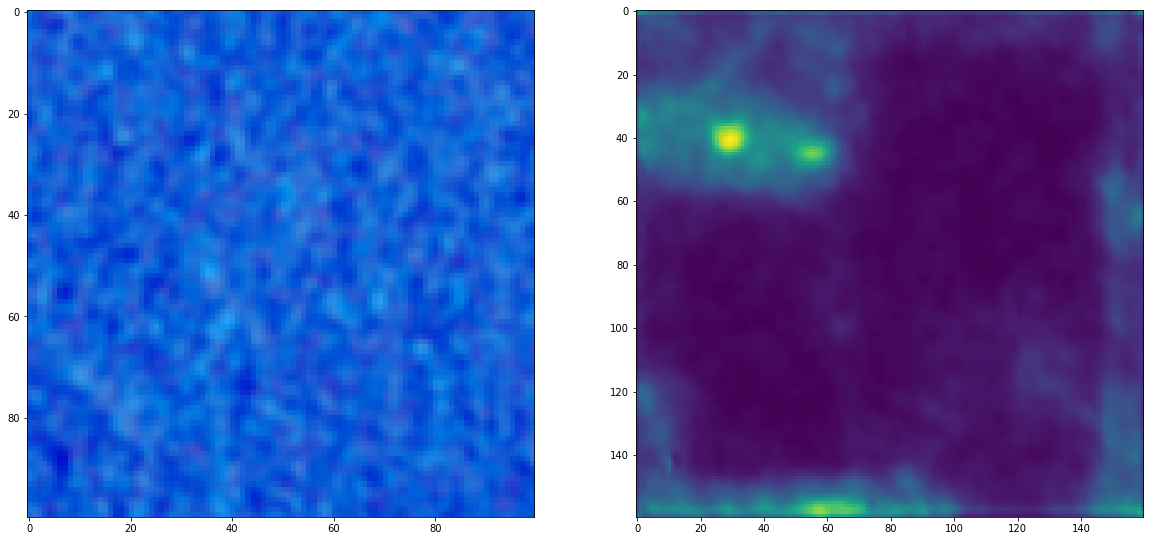

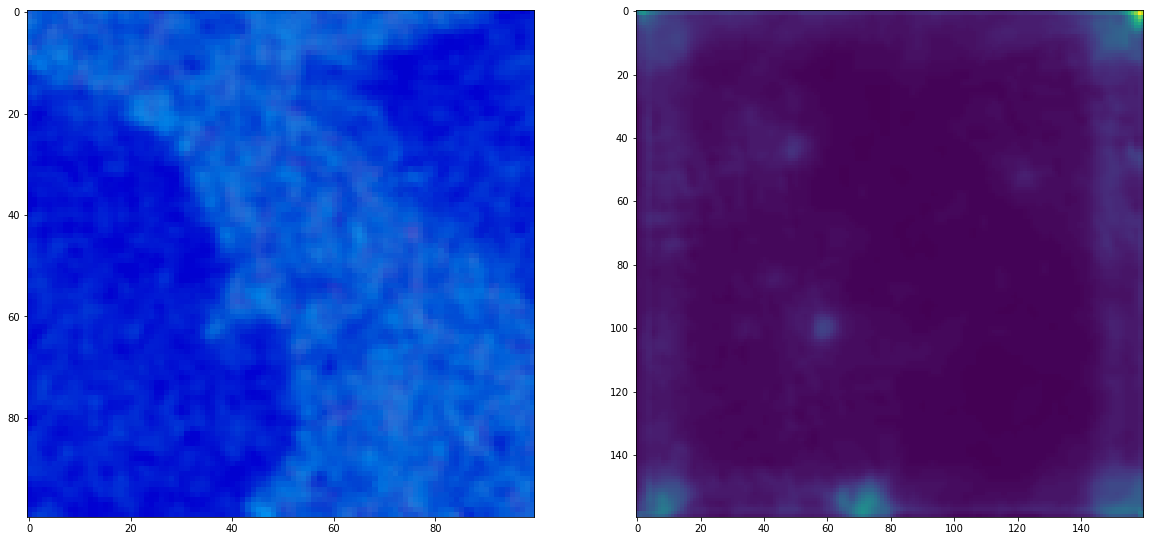

In [8]:
plot_data_results(num_samples=2, fig_size=(2, 2), predict_config=predict_config, img_ch =2, n_bands=3)

In [9]:
!rm tmp_list.txt

In [10]:
vrt_path        =  os.path.join(BASE_PATH,f'dataset_{MODELO_AREA}/data_results/','province_'+PROVINCE,YEAR,'all.vrt') # ruta de destino para nuestra predicción
predict_results =  os.path.join(BASE_PATH,f'dataset_{MODELO_AREA}/data_results/','province_'+PROVINCE,YEAR,str(size)+'_'+str(step_size),'*tif') # ruta de destino para nuestra predicción
                                                                                                     
print(predict_results)

import glob
filenames = glob.glob(predict_results)

with open('tmp_list.txt', 'w') as f:
    for line in filenames:
        f.write(line)
        f.write('\n')

!gdalbuildvrt -input_file_list tmp_list.txt $vrt_path

../dataset_atlantico/data_results/province_vichada/2017/100_100/*tif
0...10...20...30...40...50...60...70...80...90...100 - done.


### aplicar un umbral al raster

In [11]:
from tqdm import tqdm
import subprocess
import os

umbral = str(UMBRAL)
thr_tif_file = os.path.join(BASE_PATH,f'dataset_{MODELO_AREA}/data_results/','province_'+PROVINCE,YEAR,'province_'+PROVINCE+'_year'+YEAR+'_'+str(size)+'_'+str(step_size)+'_thr'+umbral+'.tif') # ruta de destino para nuestra predicción
    
exp = "((A>"+umbral+")*200)"

cmd_calc = f'gdal_calc.py -A {vrt_path} --A_band=1 --outfile {thr_tif_file} --calc="{exp}" --NoDataValue=0'
subprocess.run(cmd_calc, shell=True)


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 

8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 

11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 

15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 15.. 

18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 

21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 21.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 28.. 

31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 31.. 

34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 

38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 38.. 

41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 41.. 

44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 44.. 

47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 48.. 

51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 

54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 54.. 

57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 57.. 

61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 61.. 

64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 

67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 

70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 70.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 

74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 74.. 

77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 

80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 80.. 

84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 

87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 87.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 

93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 

97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 97.. 

CompletedProcess(args='gdal_calc.py -A ../dataset_atlantico/data_results/province_vichada/2017/all.vrt --A_band=1 --outfile ../dataset_atlantico/data_results/province_vichada/2017/province_vichada_year2017_100_100_thr130.tif --calc="((A>130)*200)" --NoDataValue=0', returncode=0)

**remove montains**

In [24]:
mask_folder = BASE_PATH + MOUNT_FOLDER 
!mkdir -p $mask_folder
!gsutil -m cp -r $BUCKET_MOUNTAINS  $mask_folder

Copying gs://dym-indunor-temp/immap/annotations_WASH/images/DEM/otros/vinchada/mask_lt_25_.tif...
/ [1/1 files][ 10.8 MiB/ 10.8 MiB] 100% Done                                    
Operation completed over 1 objects/10.8 MiB.                                     


In [27]:
!mv ../mountain_masks/$PROVINCE/$PROVINCE/mask_lt_25_.tif ../mountain_masks/$PROVINCE/

In [31]:
import subprocess

image_pred = thr_tif_file

image_1D   = BASE_PATH + MOUNT_FOLDER + ELEVATION_FILE 
print(image_1D)
image_1D_resampled   =  image_1D[:-4] + '_resampled.tif'

#resample
subprocess.run(f"bash -c 'source /opt/OTB/otbenv.profile; otbcli_Superimpose -inr {image_pred} -inm {image_1D} -out {image_1D_resampled}' ", shell=True)

pred_wout_montains_folder =  os.path.join(BASE_PATH,f'dataset_{MODELO_AREA}/data_results/','province_'+PROVINCE,'all')
!mkdir  $pred_wout_montains_folder
pred_slope   = pred_wout_montains_folder+'/all_province_'+PROVINCE+"_"+YEAR+str(size)+'_'+str(step_size)+'_slope.tif' 


!gdal_calc.py -A $image_pred --A_band=1 -B $image_1D_resampled --B_band=1 --calc="A*B" --outfile=$pred_slope 
        

../mountain_masks/vichada/mask_lt_25_.tif
2022-05-18 20:35:01 (INFO) Superimpose: Default RAM limit for OTB is 256 MB
2022-05-18 20:35:01 (INFO) Superimpose: GDAL maximum cache size is 749 MB
2022-05-18 20:35:01 (INFO) Superimpose: OTB will use at most 4 threads
2022-05-18 20:35:01 (INFO) Superimpose: Elevation management: setting default height above ellipsoid to 0 meters
2022-05-18 20:35:01 (INFO): Estimated memory for full processing: 22159.9MB (avail.: 256 MB), optimal image partitioning: 87 blocks
2022-05-18 20:35:01 (INFO): File ../mountain_masks/vichada/mask_lt_25__resampled.tif will be written in 100 blocks of 4352x4352 pixels
Writing ../mountain_masks/vichada/mask_lt_25__resampled.tif...: 100% [**************************************************] (5m 37s)
mkdir: cannot create directory ‘../dataset_atlantico/data_results/province_vichada/all’: File exists


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 

26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 

34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 

39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 39.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 40.. 

47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 55.. 

63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 63.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 64.. 

71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 71.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 72.. 

77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 77.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 78.. 

84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 

92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 

## Diferencia

In [33]:
fecha_2017 = pred_wout_montains_folder+'/all_province_'+PROVINCE+'_2017'+str(size)+'_'+str(step_size)+'_slope.tif' 
fecha_2021 = pred_wout_montains_folder+'/all_province_'+PROVINCE+'_2021'+str(size)+'_'+str(step_size)+'_slope.tif' 
fecha_2017_resampled  = pred_wout_montains_folder+'/all_province_'+PROVINCE+'_2021'+str(size)+'_'+str(step_size)+'_slope_resampled.tif' 
subprocess.run(f"bash -c 'source /opt/OTB/otbenv.profile; otbcli_Superimpose -inr {fecha_2021} -inm {fecha_2017} -out {fecha_2017_resampled}' ", shell=True)


diff = pred_wout_montains_folder+'/all_province_'+PROVINCE+'_diff_2021_2017_'+str(step_size)+'_slope.tif' 

exp = "((A>B)*199+(B>A)*99 + 1*(A==B))"

cmd_calc = f'gdal_calc.py -A {fecha_2021} --A_band=1 -B {fecha_2017_resampled} --B_band=1 --outfile {diff} --calc="{exp}" --NoDataValue=0'
subprocess.run(cmd_calc, shell=True)


2022-05-18 20:41:33 (INFO) Superimpose: Default RAM limit for OTB is 256 MB
2022-05-18 20:41:33 (INFO) Superimpose: GDAL maximum cache size is 749 MB
2022-05-18 20:41:33 (INFO) Superimpose: OTB will use at most 4 threads
2022-05-18 20:41:33 (INFO) Superimpose: Elevation management: setting default height above ellipsoid to 0 meters
2022-05-18 20:41:33 (INFO): Estimated memory for full processing: 22159.9MB (avail.: 256 MB), optimal image partitioning: 87 blocks
2022-05-18 20:41:33 (INFO): File ../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_2021100_100_slope_resampled.tif will be written in 88 blocks of 40834x454 pixels
Writing ../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_2021100_100_slope_resampled.tif...: 100% [**************************************************] (5m 08s)


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 

18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 18.. 

26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 26.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 27.. 

34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 34.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 35.. 

43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 43.. 

51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 51.. 

59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 59.. 

67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 67.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 

75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 75.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 76.. 

84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 84.. 

92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 

CompletedProcess(args='gdal_calc.py -A ../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_2021100_100_slope.tif --A_band=1 -B ../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_2021100_100_slope_resampled.tif --B_band=1 --outfile ../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_diff_2021_2017_100_slope.tif --calc="((A>B)*199+(B>A)*99 + 1*(A==B))" --NoDataValue=0', returncode=0)

In [34]:
subir = pred_wout_montains_folder+"/*"
!gsutil -m cp -r $subir $BUCKET_RESULTADOS

Copying file://../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_2021100_100_slope.tif [Content-Type=image/tiff]...
Copying file://../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_2017100_100_slope.tif [Content-Type=image/tiff]...
Copying file://../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_diff_2021_2017_100_slope.tif [Content-Type=image/tiff]...
Copying file://../dataset_atlantico/data_results/province_vichada/all/all_province_vichada_2021100_100_slope_resampled.tif [Content-Type=image/tiff]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which

In [31]:
!gsutil -m cp -r $diff gs://dym-indunor-temp/immap/resultados/

CommandException: No URLs matched: ../dataset_pacifico/data_results/province_choco/all/all_province_choco_diff_2021_2017_100_slope.tif
CommandException: 1 file/object could not be transferred.
